In [1]:
# Importowanie wymaganych bibliotek
from dask.distributed import Client
import dask.dataframe as dd
import seaborn as sns
import matplotlib.pyplot as plt

# Inicjalizacja klienta Dask
client = Client(n_workers=4, threads_per_worker=3, memory_limit="5GB")
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 12,Total memory: 18.63 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:50620,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 12
Started: Just now,Total memory: 18.63 GiB
Comm: tcp://127.0.0.1:50640,Total threads: 3
Dashboard: http://127.0.0.1:50643/status,Memory: 4.66 GiB
Nanny: tcp://127.0.0.1:50623,


In [35]:
# Wczytanie plików Parquet
df = dd.read_parquet('testData/yellow_tripdata_2023-01*.parquet')
df = df.rename(columns={'airport_fee': 'Airport_fee'})
df1 = dd.read_parquet('testData/yellow_tripdata_2023-02*.parquet')
df2 = dd.read_parquet('testData/yellow_tripdata_2023-03*.parquet')
df3 = dd.read_parquet('testData/yellow_tripdata_2023-04*.parquet')
df4 = dd.read_parquet('testData/yellow_tripdata_2023-06*.parquet')
df5 = dd.read_parquet('testData/yellow_tripdata_2023-12*.parquet')

# Łączenie wszystkich plików w jeden DataFrame
df_all = dd.concat([df, df1, df2, df3, df4, df5])

# Sprawdzenie pierwszych kilku wierszy danych
df_all.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.9,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.1,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.4,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00


In [36]:
# Liczba wierszy (rekordów)
print(len(df_all))
print()

# Sprawdzenie typów danych
print(df_all.dtypes)
print()

# Sprawdzenie brakujących wartości
print(df_all.isnull().sum().compute())
print()

19356538

VendorID                           int64
tpep_pickup_datetime      datetime64[us]
tpep_dropoff_datetime     datetime64[us]
passenger_count                  float64
trip_distance                    float64
RatecodeID                       float64
store_and_fwd_flag       string[pyarrow]
PULocationID                       int64
DOLocationID                       int64
payment_type                       int64
fare_amount                      float64
extra                            float64
mta_tax                          float64
tip_amount                       float64
tolls_amount                     float64
improvement_surcharge            float64
total_amount                     float64
congestion_surcharge             float64
Airport_fee                      float64
dtype: object

VendorID                      0
tpep_pickup_datetime          0
tpep_dropoff_datetime         0
passenger_count          606759
trip_distance                 0
RatecodeID               606759
stor

In [37]:
# Analiza unikalnych wartości w kolumnach
non_numeric_cols = df_all.select_dtypes(exclude=['number']).columns
print("Kolumny nienumeryczne:", non_numeric_cols)

Kolumny nienumeryczne: Index(['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'store_and_fwd_flag'], dtype='object')


In [38]:
# Preprocessing danych - usuwanie wierszy z brakującymi wartościami
df_cleaned = df_all.dropna()

In [39]:
# Liczba wierszy (rekordów) po usunięciu brakujących danych
print(f"Po usunięciu brakujących danych, liczba rekordów: {len(df_cleaned)}")

Po usunięciu brakujących danych, liczba rekordów: 18749779


In [40]:
# Sprawdzenie typów danych po oczyszczeniu
print(df_cleaned.dtypes)
print()

# Sprawdzenie brakujących wartości po oczyszczeniu
print(df_cleaned.isnull().sum().compute())
print()

VendorID                           int64
tpep_pickup_datetime      datetime64[us]
tpep_dropoff_datetime     datetime64[us]
passenger_count                  float64
trip_distance                    float64
RatecodeID                       float64
store_and_fwd_flag       string[pyarrow]
PULocationID                       int64
DOLocationID                       int64
payment_type                       int64
fare_amount                      float64
extra                            float64
mta_tax                          float64
tip_amount                       float64
tolls_amount                     float64
improvement_surcharge            float64
total_amount                     float64
congestion_surcharge             float64
Airport_fee                      float64
dtype: object

VendorID                 0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
RatecodeID               0
store_and_fwd_flag       0
PULocationID     

In [41]:
# Dodanie nowej cechy czas trwania podróży (w sekundach)
df_cleaned['trip_duration'] = (df_cleaned['tpep_dropoff_datetime'] - df_cleaned['tpep_pickup_datetime']).dt.total_seconds()
df_cleaned.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,trip_duration
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00,506.0
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00,379.0
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.9,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00,765.0
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.1,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25,577.0
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.4,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00,650.0


In [42]:
# Dodajemy kolumnę 'hour' z godziny z 'tpep_pickup_datetime'
df_cleaned['hour'] = df_cleaned['tpep_pickup_datetime'].dt.hour
df_cleaned.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,trip_duration,hour
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,...,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00,506.0,0
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,...,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00,379.0,0
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,...,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00,765.0,0
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,...,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25,577.0,0
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,...,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00,650.0,0


In [43]:
# Filtracja danych: pozostawiamy tylko dane z roku 2023
df_cleaned = df_cleaned[df_cleaned['tpep_pickup_datetime'].dt.year == 2023]
df_cleaned = df_cleaned[df_cleaned['tpep_dropoff_datetime'].dt.year == 2023]

# Wizualizacja danych:

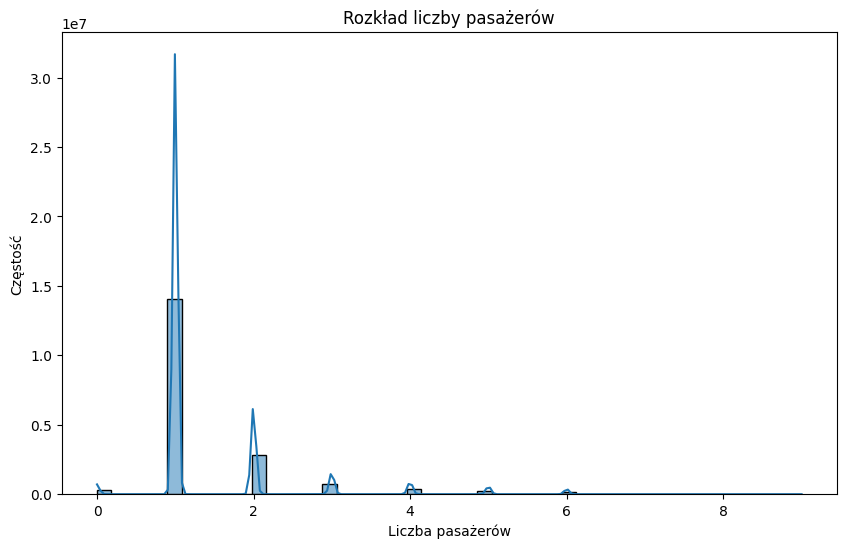

In [44]:
# 1. Rozkład liczby pasażerów
plt.figure(figsize=(10, 6))
sns.histplot(df_cleaned['passenger_count'].compute(), kde=True, bins=50)
plt.title("Rozkład liczby pasażerów")
plt.xlabel('Liczba pasażerów')
plt.ylabel('Częstość')
plt.show()

In [45]:
# Odrzucenie 1% najbardziej ekstremalnych danych
q99 = df_cleaned['passenger_count'].quantile(0.99).compute()
print(f"99. percentyl: {q99}")

# Usunięcie rekordów z passenger_count powyżej q99
df_cleaned_filtered = df_cleaned[df_cleaned['passenger_count'] <= q99]

99. percentyl: 5.0


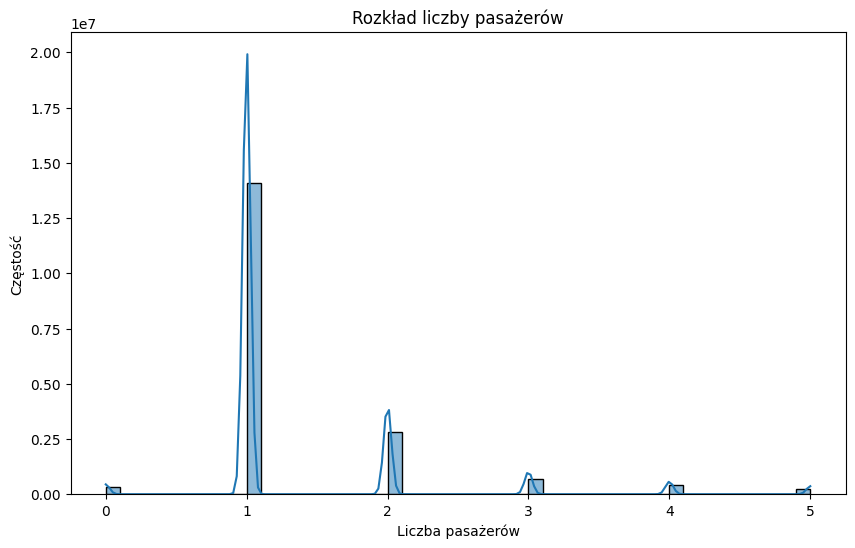

In [46]:
# 1.1 Rozkład liczby pasażerów
plt.figure(figsize=(10, 6))
sns.histplot(df_cleaned_filtered['passenger_count'].compute(), kde=True, bins=50)
plt.title("Rozkład liczby pasażerów")
plt.xlabel('Liczba pasażerów')
plt.ylabel('Częstość')
plt.show()

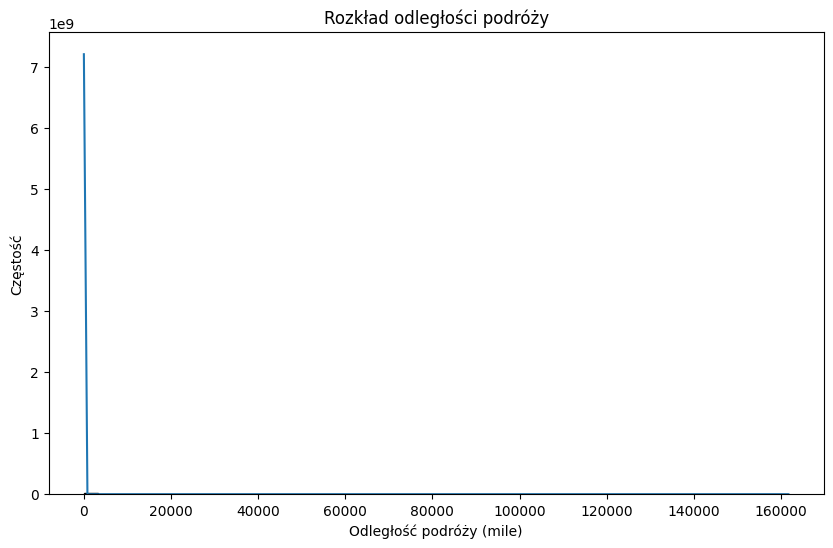

In [47]:
# 2. Rozkład odległości podróży
plt.figure(figsize=(10, 6))
sns.histplot(df_cleaned['trip_distance'].compute(), kde=True, bins=50)
plt.title("Rozkład odległości podróży")
plt.xlabel('Odległość podróży (mile)')
plt.ylabel('Częstość')
plt.show()

In [48]:
# Odrzucenie 1% najbardziej ekstremalnych danych
q99 = df_cleaned['trip_distance'].quantile(0.99).compute()
print(f"99. percentyl: {q99}")

# Usunięcie rekordów z trip_distance powyżej q99
df_cleaned_filtered = df_cleaned_filtered[df_cleaned_filtered['trip_distance'] <= q99]

# Usunięcie rekordów, gdzie trip_distance jest równe 0 mil
df_cleaned_filtered = df_cleaned_filtered[df_cleaned_filtered['trip_distance'] > 0]

99. percentyl: 20.49


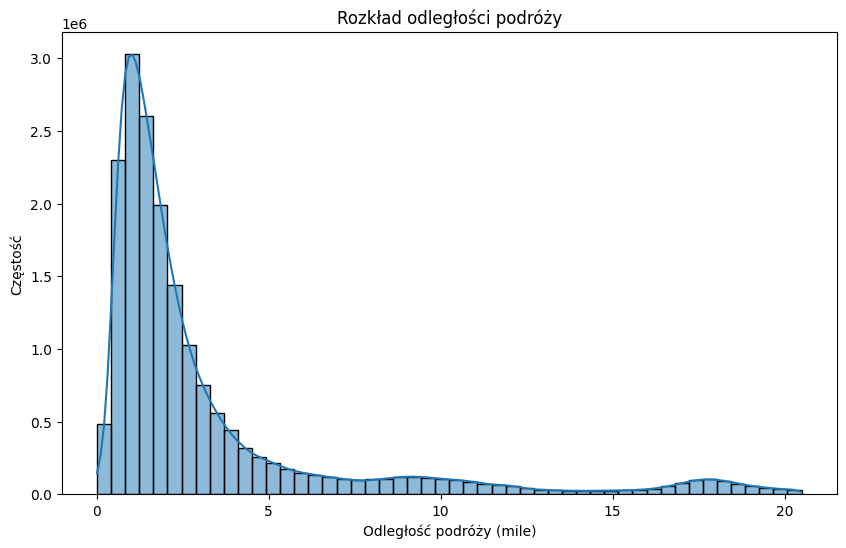

In [49]:
# 2.1 Rozkład odległości podróży
plt.figure(figsize=(10, 6))
sns.histplot(df_cleaned_filtered['trip_distance'].compute(), kde=True, bins=50)
plt.title("Rozkład odległości podróży")
plt.xlabel('Odległość podróży (mile)')
plt.ylabel('Częstość')
plt.show()

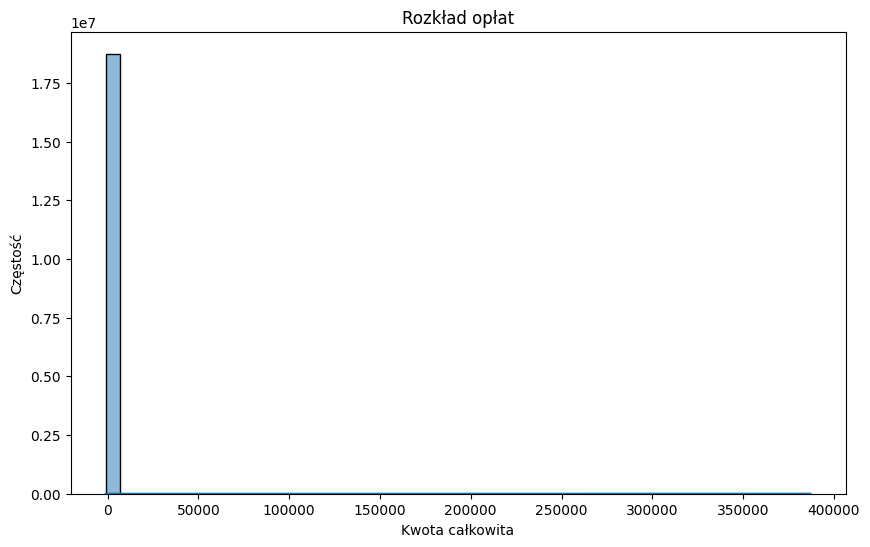

In [50]:
# 3. Rozkład opłat
plt.figure(figsize=(10, 6))
sns.histplot(df_cleaned['total_amount'].compute(), kde=True, bins=50)
plt.title("Rozkład opłat")
plt.xlabel('Kwota całkowita')
plt.ylabel('Częstość')
plt.show()

In [51]:
# Odrzucenie 1% najbardziej ekstremalnych danych
q99 = df_cleaned['total_amount'].quantile(0.99).compute()
print(f"99. percentyl: {q99}")

# Usunięcie rekordów z total_amount powyżej q99
df_cleaned_filtered = df_cleaned_filtered[df_cleaned_filtered['total_amount'] <= q99]

# Usunięcie rekordów, gdzie total_amount jest równe 0
df_cleaned_filtered = df_cleaned_filtered[df_cleaned_filtered['total_amount'] > 0]

99. percentyl: 105.0


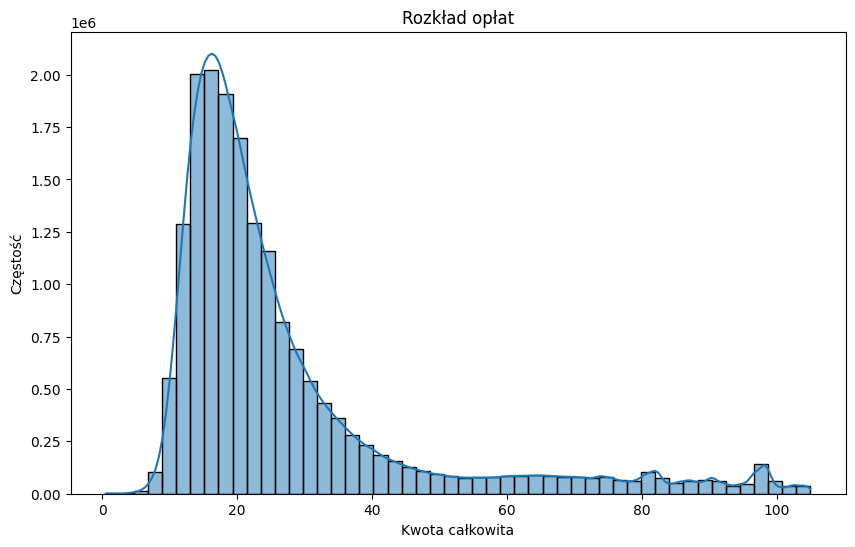

In [52]:
# 3.1 Rozkład opłat
plt.figure(figsize=(10, 6))
sns.histplot(df_cleaned_filtered['total_amount'].compute(), kde=True, bins=50)
plt.title("Rozkład opłat")
plt.xlabel('Kwota całkowita')
plt.ylabel('Częstość')
plt.show()

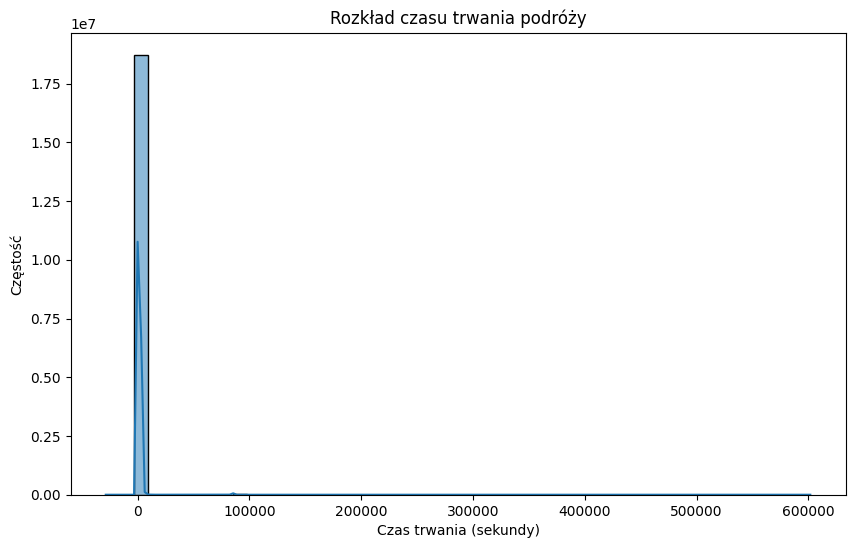

In [53]:
# 4. Rozkład czasu trwania podróży
plt.figure(figsize=(10, 6))
sns.histplot(df_cleaned['trip_duration'].compute(), kde=True, bins=50)
plt.title("Rozkład czasu trwania podróży")
plt.xlabel('Czas trwania (sekundy)')
plt.ylabel('Częstość')
plt.show()

In [54]:
# Odrzucenie 1% najbardziej ekstremalnych danych
q99 = df_cleaned['trip_duration'].quantile(0.99).compute()
print(f"99. percentyl: {q99}")

# Usunięcie rekordów z trip_duration powyżej q99
df_cleaned_filtered = df_cleaned_filtered[df_cleaned_filtered['trip_duration'] <= q99]

# Usunięcie rekordów, gdzie trip_duration jest równe 0
df_cleaned_filtered = df_cleaned_filtered[df_cleaned_filtered['trip_duration'] > 0]

99. percentyl: 4386.0


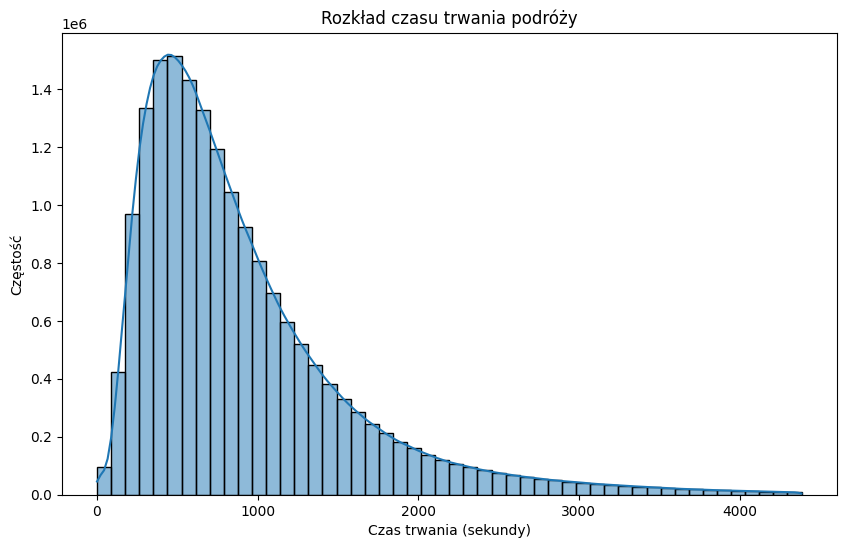

In [55]:
# 4.1 Rozkład czasu trwania podróży
plt.figure(figsize=(10, 6))
sns.histplot(df_cleaned_filtered['trip_duration'].compute(), kde=True, bins=50)
plt.title("Rozkład czasu trwania podróży")
plt.xlabel('Czas trwania (sekundy)')
plt.ylabel('Częstość')
plt.show()

<!-- Tutaj te filtered_data zamienić na to gdzie wszędzie wrzucam -->

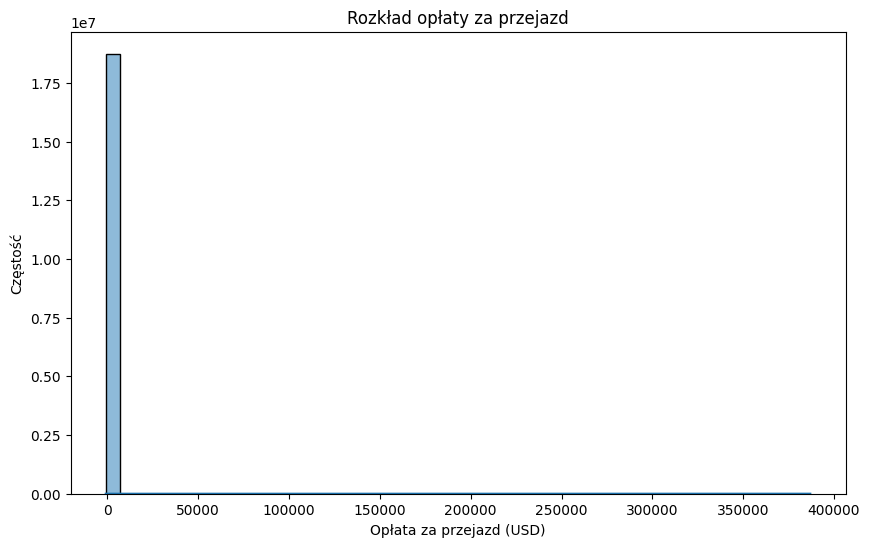

In [56]:
# 5. Rozkład opłaty za przejazd
plt.figure(figsize=(10, 6))
sns.histplot(df_cleaned['fare_amount'].compute(), kde=True, bins=50)
plt.title("Rozkład opłaty za przejazd")
plt.xlabel('Opłata za przejazd (USD)')
plt.ylabel('Częstość')
plt.show()

In [57]:
# Odrzucenie 1% najbardziej ekstremalnych danych
q99 = df_cleaned['fare_amount'].quantile(0.99).compute()
print(f"99. percentyl: {q99}")

# Usunięcie rekordów z fare_amount powyżej q99
df_cleaned_filtered = df_cleaned_filtered[df_cleaned_filtered['fare_amount'] <= q99]

# Usunięcie rekordów, gdzie fare_amount jest równe 0
df_cleaned_filtered = df_cleaned_filtered[df_cleaned_filtered['fare_amount'] > 0]

99. percentyl: 80.0


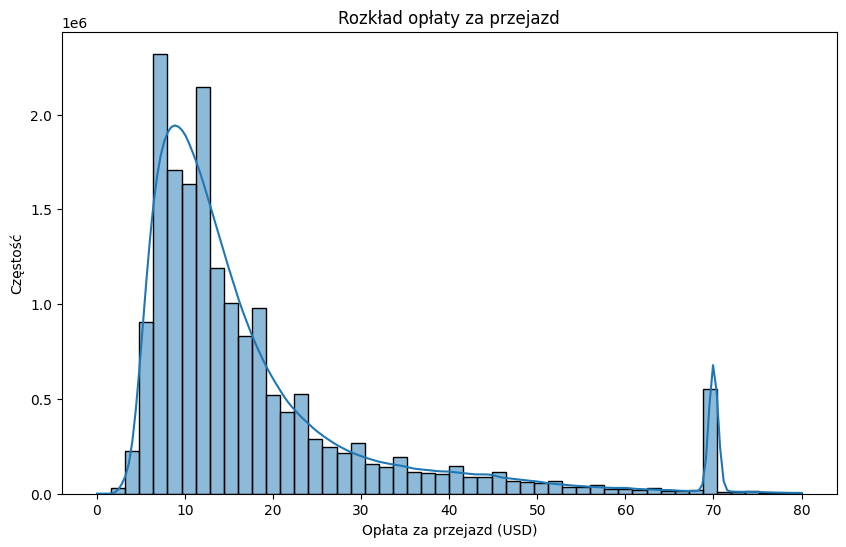

In [62]:
# 5.1 Rozkład opłaty za przejazd
plt.figure(figsize=(10, 6))
sns.histplot(df_cleaned_filtered['fare_amount'].compute(), kde=True, bins=50)
plt.title("Rozkład opłaty za przejazd")
plt.xlabel('Opłata za przejazd (USD)')
plt.ylabel('Częstość')
plt.show()

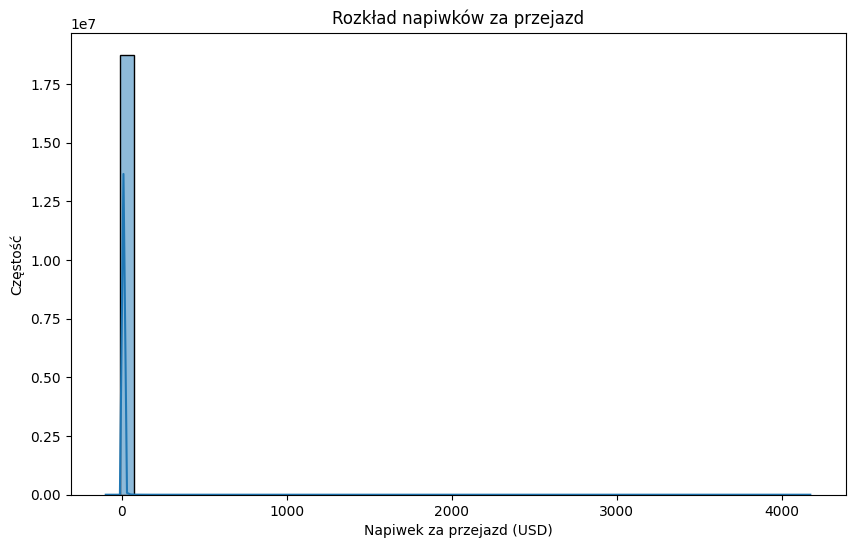

In [61]:
# 6. Rozkład napiwków za przejazd
plt.figure(figsize=(10, 6))
sns.histplot(df_cleaned['tip_amount'].compute(), kde=True, bins=50)
plt.title("Rozkład napiwków za przejazd")
plt.xlabel('Napiwek za przejazd (USD)')
plt.ylabel('Częstość')
plt.show()

In [63]:
# Odrzucenie 1% najbardziej ekstremalnych danych
q99 = df_cleaned['tip_amount'].quantile(0.99).compute()
print(f"99. percentyl: {q99}")

# Usunięcie rekordów z tip_amount powyżej q99
df_cleaned_filtered = df_cleaned_filtered[df_cleaned_filtered['tip_amount'] <= q99]

# Usunięcie rekordów, gdzie tip_amount jest równe 0
df_cleaned_filtered = df_cleaned_filtered[df_cleaned_filtered['tip_amount'] > 0]

99. percentyl: 18.5


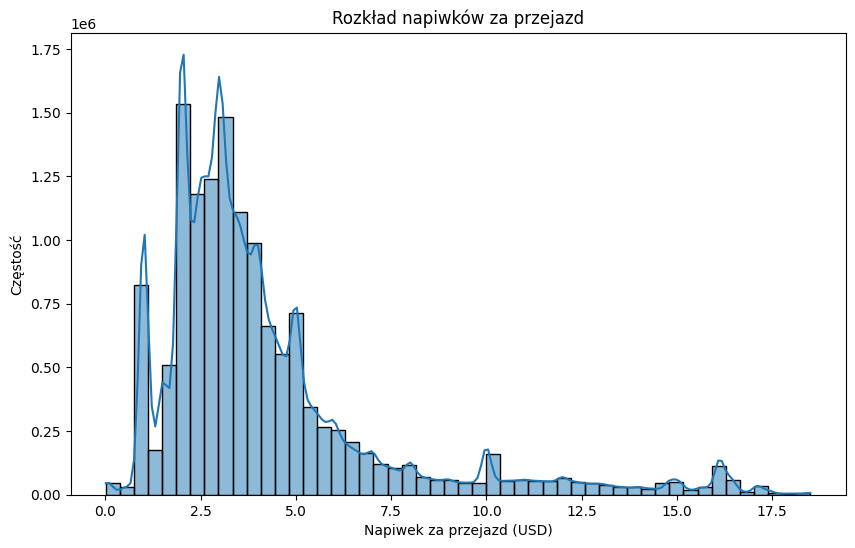

In [64]:
# 6.1 Rozkład napiwków za przejazd
plt.figure(figsize=(10, 6))
sns.histplot(df_cleaned_filtered['tip_amount'].compute(), kde=True, bins=50)
plt.title("Rozkład napiwków za przejazd")
plt.xlabel('Napiwek za przejazd (USD)')
plt.ylabel('Częstość')
plt.show()

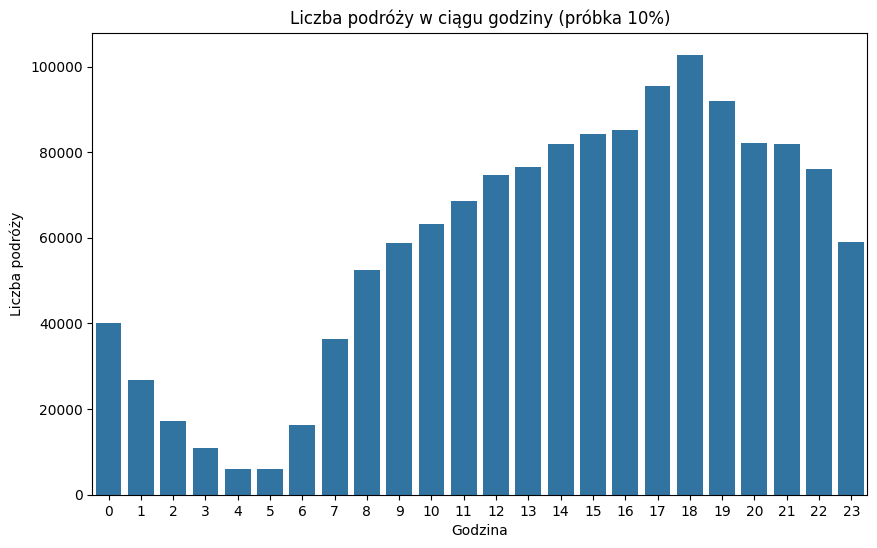

In [68]:
# Losowanie 10% próby danych (cały DataFrame)
df_sample = df_cleaned_filtered.sample(frac=0.1, random_state=42)

# Agregacja: liczba podróży dla każdej godziny (próbka 10%)
hourly_counts = df_sample.groupby('hour').size().compute()

# Wizualizacja liczby podróży w ciągu godziny
plt.figure(figsize=(10, 6))
sns.barplot(x=hourly_counts.index, y=hourly_counts.values)
plt.title("Liczba podróży w ciągu godziny (próbka 10%)")
plt.xlabel("Godzina")
plt.ylabel("Liczba podróży")
plt.xticks(range(0, 24))
plt.show()


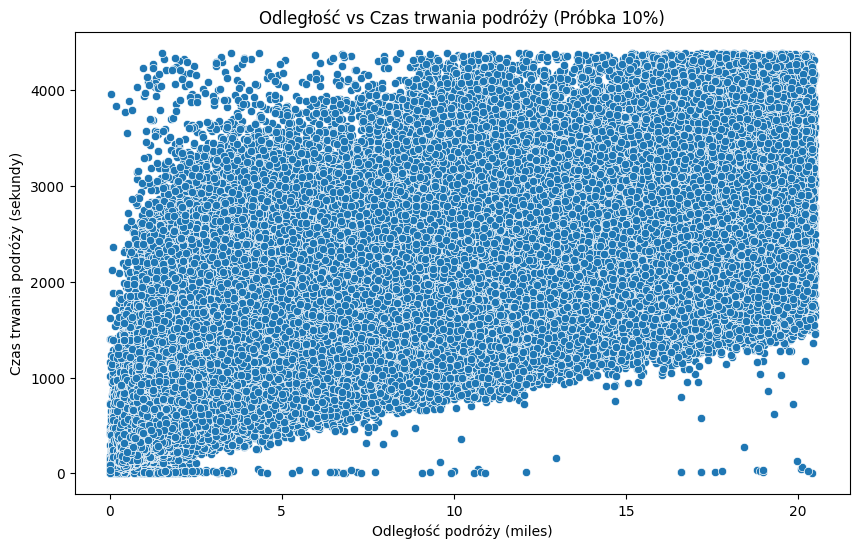

In [69]:
# Losowanie 10% danych
sample_df = df_cleaned_filtered.sample(frac=0.1, random_state=42)

# Wizualizacja odległości vs czasu trwania podróży
plt.figure(figsize=(10, 6))
sns.scatterplot(x='trip_distance', y='trip_duration', data=sample_df.compute())
plt.title("Odległość vs Czas trwania podróży (Próbka 10%)")
plt.xlabel('Odległość podróży (miles)')
plt.ylabel('Czas trwania podróży (sekundy)')
plt.show()

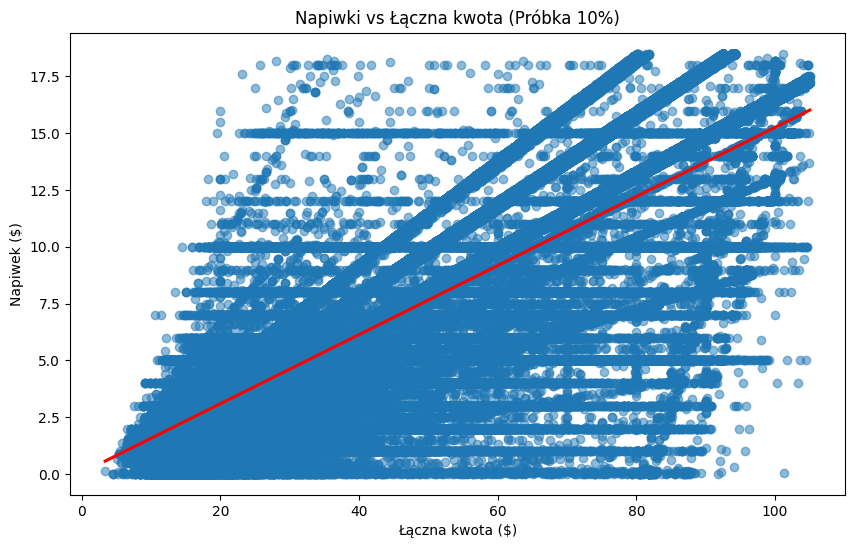

In [70]:
# Losowanie 10% danych
sample_df = df_cleaned_filtered.sample(frac=0.1, random_state=42)

# Wizualizacja: Napiwki vs Łączna kwota
plt.figure(figsize=(10, 6))
sns.regplot(x='total_amount', y='tip_amount', data=sample_df.compute(), scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.title("Napiwki vs Łączna kwota (Próbka 10%)")
plt.xlabel('Łączna kwota ($)')
plt.ylabel('Napiwek ($)')
plt.show()


In [71]:
# Liczba wszystkich wierszy
total_records = len(df_all)

# Liczba wierszy po przeprowadzeniu analizy i usunięciu brakujących danych i odstających
filtered_records = len(df_cleaned_filtered)

# Obliczenie procentu usuniętych danych
deleted_percentage = ((total_records - filtered_records) / total_records) * 100

# Wyświetlenie wyników
print(f"Liczba wszystkich rekordów: {total_records}")
print(f"Po przeprowadzeniu analizy, liczba rekordów: {filtered_records}")
print(f"Procent usuniętych danych: {deleted_percentage:.2f}%")


Liczba wszystkich rekordów: 19356538
Po przeprowadzeniu analizy, liczba rekordów: 13951964
Procent usuniętych danych: 27.92%


In [72]:
# Ścieżka do katalogu, w którym będą zapisane pliki Parquet
output_path = 'output_directory/'

# Podzielimy dane na pliki, wybierając 10 partycji
df_dask = df_cleaned_filtered.repartition(npartitions=30)

# Zapisz dane w formacie Parquet (wielu plików o równych rozmiarach)
df_dask.to_parquet(output_path, engine='pyarrow', compression='snappy', write_index=False)

# Policz liczbę rekordów w każdej partycji
df_dask.map_partitions(len).compute()

0     446803
1     446803
2     446804
3     446803
4     446804
5     427564
6     427565
7     427565
8     427565
9     427565
10    496444
11    496444
12    496445
13    496444
14    496445
15    473583
16    473583
17    473584
18    473583
19    473584
20    475251
21    475252
22    475251
23    475252
24    475252
25    470745
26    470745
27    470745
28    470745
29    470746
dtype: int64

In [73]:
client.close()